In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
### Helper Functions
def result(predictions):
    predictions = predictions.tolist()
    result_list=[]
    for pred in predictions:
        result = pred // 0.5 * 0.5
        if (pred - result) > 0.25:
            result += 0.5
        if result < 1.0:
            result = 1.0
        if result > 5.0:
            result = 5.0
        result_list.append(result)
    return result_list

### Three Measurements Functions
def accuracy(Ypred, Ytrue):
    Ytrue = Ytrue.tolist()
    accurate = 0
    for i in range(len(Ytrue)):
        if Ytrue[i] == Ypred[i]:
            accurate += 1
    return accurate / len(Ytrue)

def accuracy_range(Ytrue, Ypred):
    Ytrue=Ytrue.tolist()
    accurate_range=0
    for i in range(len(Ytrue)):
        if abs(Ytrue[i] - Ypred[i])<=0.5:
            accurate_range+=1
    return accurate_range/len(Ytrue)

# Total error / total number of points => by average what's the error for each point
def error_rate(Ytrue, Ypred):
    Ytrue=Ytrue.tolist()
    error=0
    for i in range(len(Ytrue)):
        error += abs(Ytrue[i] - Ypred[i])
    return error/len(Ytrue)

# Model1 - Use prediction of vocabulary to train model for cohesion
### 1. First Train on Vocabulary

(1) Splite the train/test data for predicting Vocabulary \
(2) Train the Decision Tree and use GridSearch to tune the max_depth, criterion, min_sample_split

In [3]:
df = pd.read_csv('./Processed_Data.csv')
y = df['vocabulary']
X = df.iloc[:, 7:]
X = X.drop("corrected_text", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [4]:
warnings.filterwarnings('ignore')
model = DecisionTreeRegressor()
parameters = {'max_depth':[0,1,2,3,4,5,6,7,8,9,10],
             'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'min_samples_split':[0,1,2,3,4,5,6,7,8,9,10]}
randm_src = GridSearchCV(model, parameters, n_jobs=-1)
randm_src.fit(X_train, y_train)
print(randm_src.best_params_)
print(randm_src.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_split': 2}
0.31632139906990203


In [5]:
dt = DecisionTreeRegressor(random_state=3, max_depth = 4,criterion='friedman_mse',min_samples_split=2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
new_pre = result(y_pred)

(3) Store the model and evaluate the performance

In [6]:
import pickle
pickle.dump(dt, open('./Models_sav/Decision_Tree_vocab.sav','wb'))

In [7]:
print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test, y_pred), accuracy(new_pre, y_test), error_rate(y_test, new_pre)))

accuracy range: 0.7088122605363985 
 accuracy: 0.4061302681992337 
 error rate: 0.37611749680715195 



(4) Tree plot

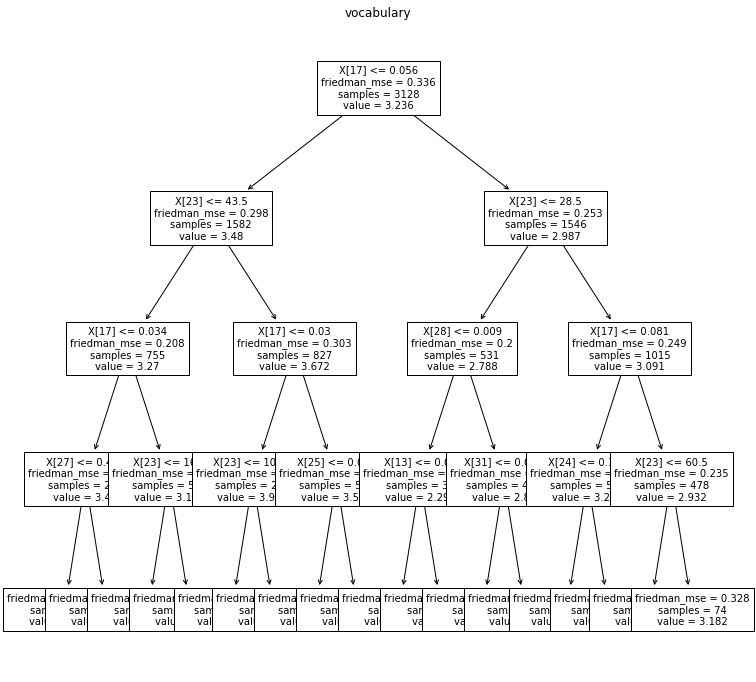

In [8]:
plt.figure(figsize=(12,12)) 
tree.plot_tree(dt,fontsize=10)
plt.title('vocabulary')
plt.show()

### Feature importance analysis

In [9]:
importance = dt.feature_importances_.tolist()

In [13]:
imp = [13, 17, 23, 24, 25, 27, 28, 31]
col_names = X_train.columns.values.tolist()
for i in imp:
    print("%s: %s" % (col_names[i], importance[i]))

sentiment_positive: 0.008510370040661498
Incorrect_form_ratio: 0.6259381006759451
number_of_diff_words: 0.29790421493480446
freq_diff_words: 0.009832435702349774
ttr: 0.01490492076512783
lexrank_avg_min_diff: 0.008925363767208368
lexrank_interquartile: 0.02072784693807113
freq_of_pronoun: 0.013256747175831961


<AxesSubplot:title={'center':'vocabulary'}, xlabel='feature name'>

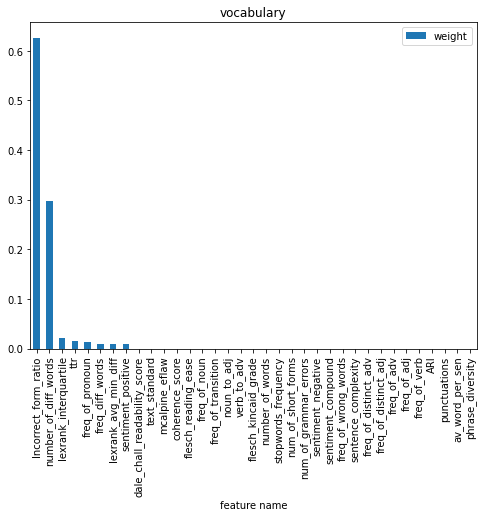

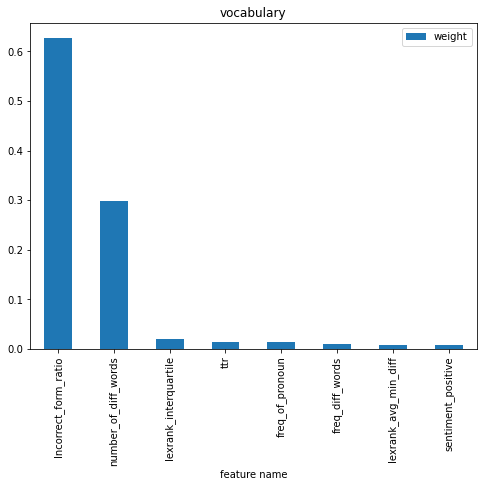

In [10]:
import numpy as np
feature_importance = pd.DataFrame([list(X_train.columns.values), importance]).T
feature_importance = feature_importance.sort_values(by=1, ascending=False)
feature_importance.columns=['feature name', 'weight']
feature_importance.plot(kind='bar',x=0, y=1, figsize=(8,6), title='vocabulary')
feature_importance.head(8).plot(kind='bar',x=0, y=1, figsize=(8,6),title='vocabulary')

### 2. Use prediction vocabulary as a new feature to predict cohesion
(1) Add Vocabulary prediction to train set and splite the train/test data for predicting Cohesion \
(2) Train the Decision Tree and use GridSearch to tune the max_depth, criterion, min_sample_split

In [11]:
y_coh = df['cohesion']
new_X = X.iloc[:]
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_X, y_coh, test_size=0.2, random_state=1)

In [12]:
y_pred_train = dt.predict(X_train1)

In [13]:
X_train1['vocabulary_predict'] = y_pred_train
X_test1['vocabulary_predict'] = y_pred

In [14]:
warnings.filterwarnings('ignore')
model = DecisionTreeRegressor()
parameters = {'max_depth':[0,1,2,3,4,5,6,7,8,9,10],
             'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'min_samples_split':[0,1,2,3,4,5,6,7,8,9,10]}
new_randm_src = GridSearchCV(model, parameters, n_jobs=-1)
new_randm_src.fit(X_train1, y_train1)
print(new_randm_src.best_params_)
print(new_randm_src.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2}
0.27825569549778617


In [15]:
new_dt = DecisionTreeRegressor(random_state=3, max_depth = 3,criterion='friedman_mse',min_samples_split=2)
new_dt.fit(X_train1, y_train1)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=3)

(3) Store the model

In [16]:
pickle.dump(new_dt, open('Decision_Tree_cohesion.sav','wb'))

In [17]:
new_y_pred = new_dt.predict(X_test1)
new_pre_adj = result(new_y_pred)
print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test1, new_y_pred), accuracy(new_pre_adj, y_test1), error_rate(y_test1, new_pre_adj)))

accuracy range: 0.5900383141762452 
 accuracy: 0.3282247765006386 
 error rate: 0.454661558109834 



(4) Tree plot

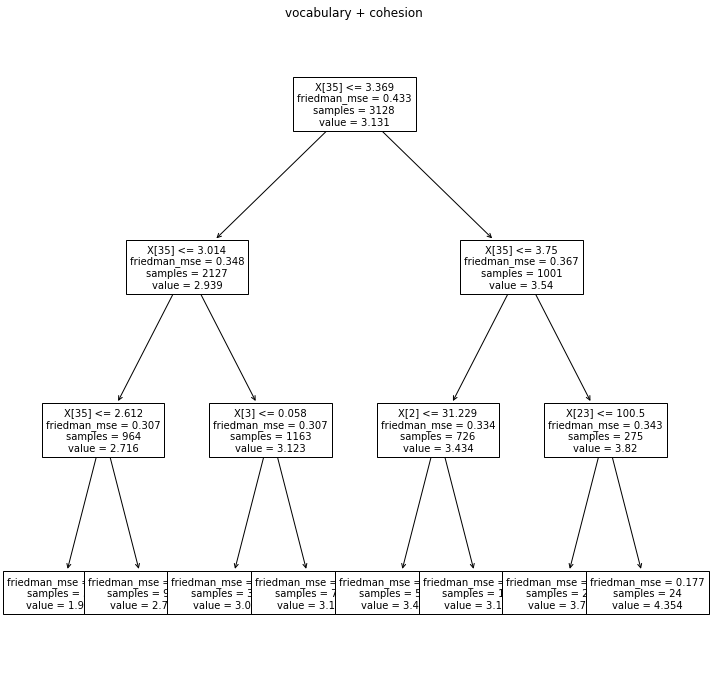

In [18]:
plt.figure(figsize=(12,12)) 
tree.plot_tree(new_dt,fontsize=10)
plt.title('vocabulary + cohesion')
plt.show()

### Visualize the distribution of difference

In [19]:
import matplotlib.pyplot as plt
def result_diff_plot(Ytrue,Ypred):
    diff=Ytrue-Ypred
    plt.hist(diff, 30)
    plt.xlabel('Difference to Results')
    plt.ylabel('Total Counts')
    plt.title('Distribution of Difference Between Prediction and True Score')
    plt.grid(True)
    plt.show()

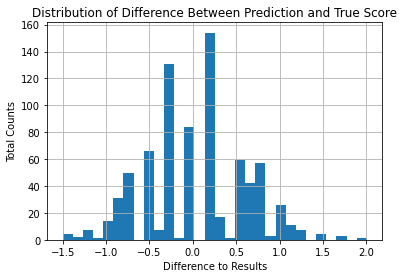

In [20]:
result_diff_plot(new_y_pred, y_test1)

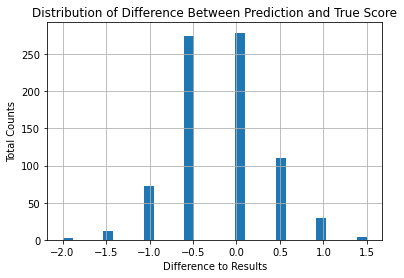

In [21]:
result_diff_plot(new_pre_adj, y_test)

Feature importance for vocabulary + cohesion

In [23]:
importance1 = new_dt.feature_importances_
feature_importance1 = pd.DataFrame([list(X_train1.columns.values), importance1]).T
feature_importance1 = feature_importance1.sort_values(by=1, ascending=False)
feature_importance1.columns=['feature name', 'weight']
feature_importance1

,feature name,weight
35,vocabulary_predict,0.930594
2,av_word_per_sen,0.032817
3,punctuations,0.018405
23,number_of_diff_words,0.018185
27,lexrank_avg_min_diff,0.0
21,text_standard,0.0
22,mcalpine_eflaw,0.0
24,freq_diff_words,0.0
25,ttr,0.0
26,coherence_score,0.0


<AxesSubplot:title={'center':'vocabulary + cohesion'}, xlabel='feature name'>

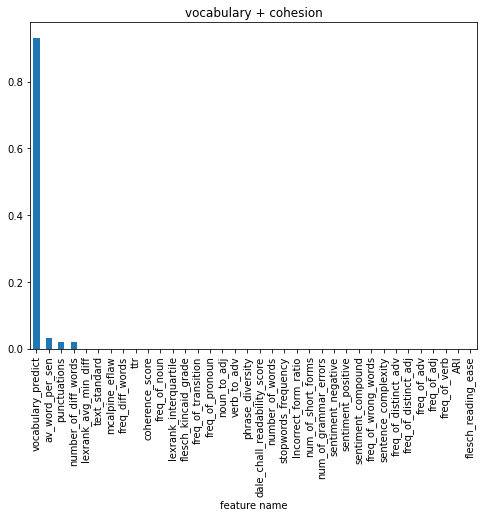

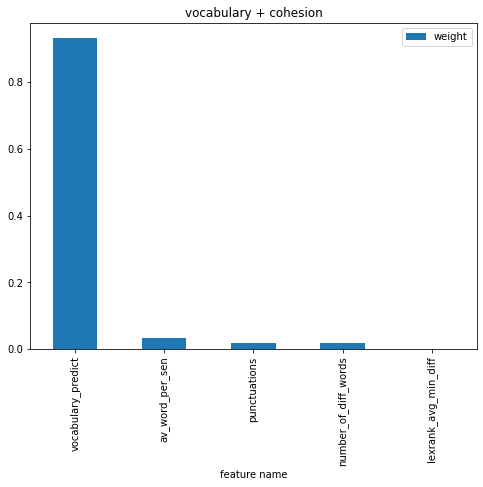

In [24]:
feature_importance1.plot(kind='bar',x=0, y=1, figsize=(8,6),title='vocabulary + cohesion',legend=False)
feature_importance1.head(5).plot(kind='bar',x=0, y=1, figsize=(8,6),title='vocabulary + cohesion')

# Model2 - Directly train the model for cohesion

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_coh, test_size=0.2, random_state=1)

In [26]:
dt2 = DecisionTreeRegressor(random_state=3, max_depth = 3)
dt2.fit(X_train2, y_train2)
y_pred2 = dt2.predict(X_test2)
new_pre2 = result(y_pred2)
print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test2, y_pred2), accuracy(new_pre2, y_test2), error_rate(y_test2, new_pre2)))

accuracy range: 0.5810983397190294 
 accuracy: 0.2950191570881226 
 error rate: 0.47445721583652617 



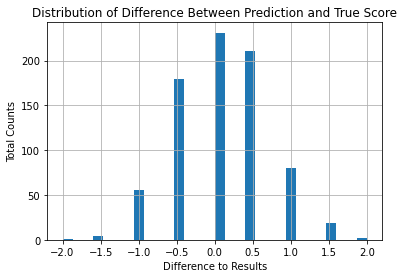

In [27]:
result_diff_plot(new_pre2, y_test1)

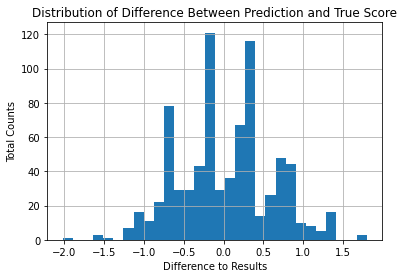

In [28]:
result_diff_plot(y_pred2, y_test1)

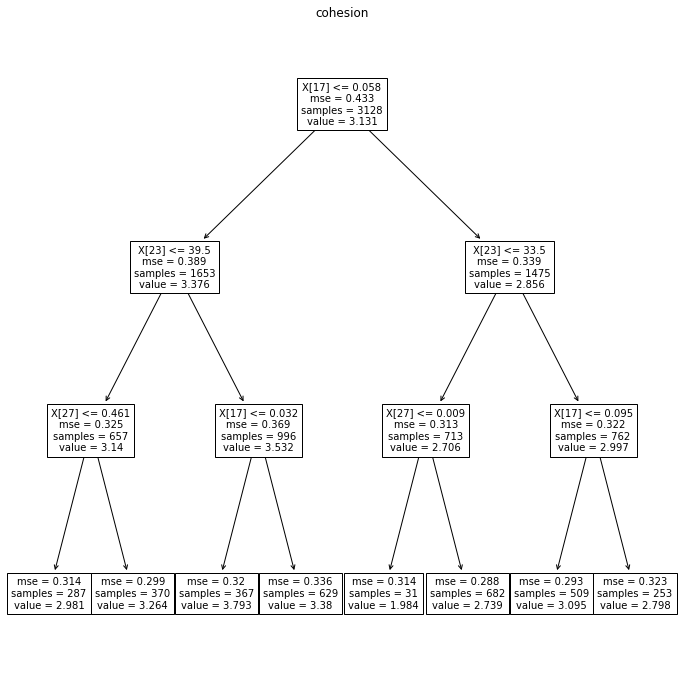

In [29]:
plt.figure(figsize=(12,12)) 
tree.plot_tree(dt2,fontsize=10)
plt.title('cohesion')
plt.show()

Feature importance for cohesion

In [30]:
importance2 = dt2.feature_importances_
feature_importance2 = pd.DataFrame([list(X_train2.columns.values), importance2]).T
feature_importance2 = feature_importance2.sort_values(by=1, ascending=False)
feature_importance2.columns=['feature name', 'weight']
feature_importance2

,feature name,weight
17,Incorrect_form_ratio,0.685304
23,number_of_diff_words,0.237628
27,lexrank_avg_min_diff,0.077068
32,noun_to_adj,0.0
31,freq_of_pronoun,0.0
30,freq_of_transition,0.0
29,freq_of_noun,0.0
28,lexrank_interquartile,0.0
18,flesch_reading_ease,0.0
26,coherence_score,0.0


<AxesSubplot:title={'center':'cohesion'}, xlabel='feature name'>

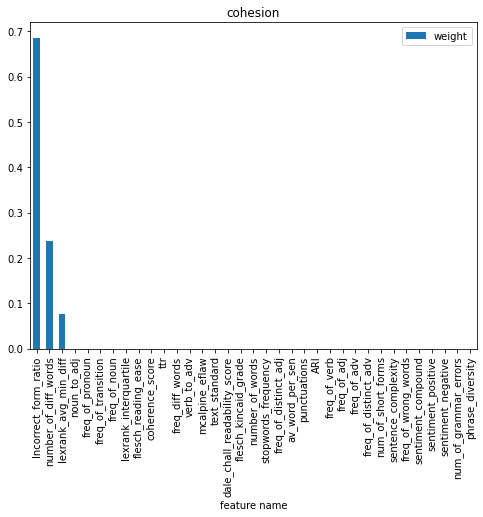

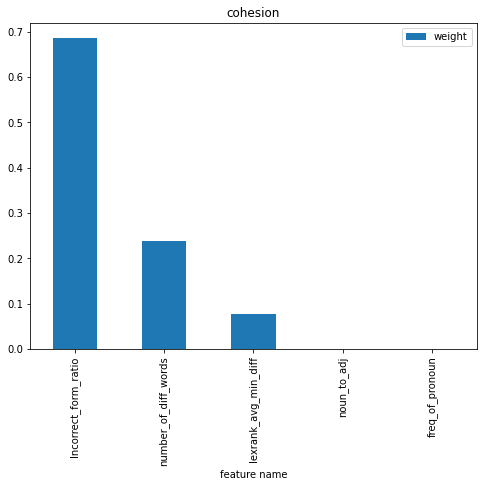

In [31]:
feature_importance2.plot(kind='bar',x=0, y=1, figsize=(8,6),title='cohesion')
feature_importance2.head(5).plot(kind='bar',x=0, y=1, figsize=(8,6),title='cohesion')

# Model3 - Use rounded Volcabulary as feature to train the model
This is an adjustment to Model 1. The difference is instead of using the numerical results from model predicting vocabulary as new feature, we use the rounded up vocabulary prediction as new input.

In [32]:
X_train3 = X_train1.loc[:]
X_test3 = X_test1.loc[:]
X_train3['vocabulary_predict'] = result(y_pred_train)
X_test3['vocabulary_predict'] = new_pre

In [33]:
warnings.filterwarnings('ignore')
model = DecisionTreeRegressor()
parameters = {'max_depth':[0,1,2,3,4,5,6,7,8,9,10],
             'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'min_samples_split':[0,1,2,3,4,5,6,7,8,9,10]}
new_randm_src = GridSearchCV(model, parameters, n_jobs=-1)
new_randm_src.fit(X_train3, y_train1)
print(new_randm_src.best_params_)
print(new_randm_src.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2}
0.2549034118204867


In [34]:
dt3 = DecisionTreeRegressor(random_state=3, max_depth = 3,criterion='friedman_mse',min_samples_split=2)
dt3.fit(X_train3, y_train1)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=3)

In [35]:
y_pred3 = dt3.predict(X_test3)
new_pre3 = result(y_pred3)
print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test1, y_pred3), accuracy(new_pre3, y_test1), error_rate(y_test1, new_pre3)))

accuracy range: 0.5887611749680716 
 accuracy: 0.3103448275862069 
 error rate: 0.4706257982120051 



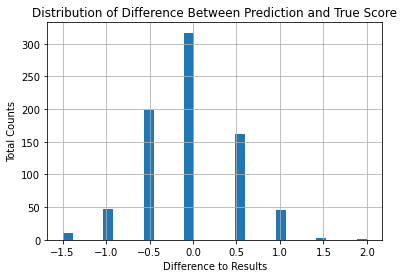

In [36]:
result_diff_plot(new_pre3, y_test)

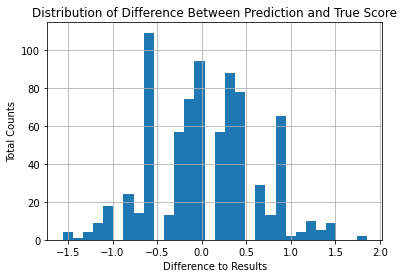

In [37]:
result_diff_plot(y_pred3, y_test1)

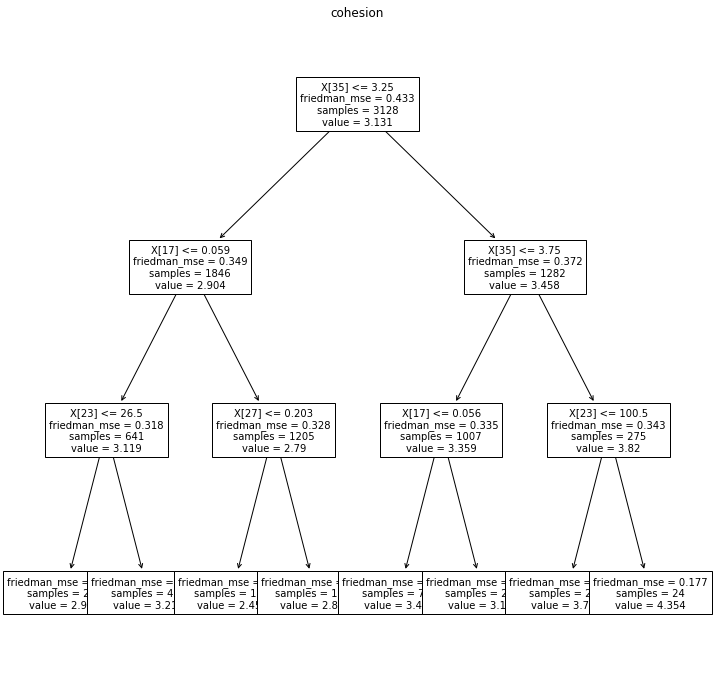

In [38]:
plt.figure(figsize=(12,12)) 
tree.plot_tree(dt3,fontsize=10)
plt.title('cohesion')
plt.show()